In [1]:
import gymnasium as gym
import rl_dbs.gym_oscillator
import rl_dbs.gym_oscillator.envs
import rl_dbs.oscillator_cpp
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import os

# env = gym.make('oscillator-v0')
env = rl_dbs.gym_oscillator.envs.oscillatorEnv()

In [10]:
class CustomCallback(BaseCallback):
    def __init__(self, save_freq, save_path, verbose=0):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        self.states = []          # 상태 기록
        self.actions = []         # 행동 기록
        self.rewards = []         # 보상 기록
        self.actor_losses = []    # Actor Loss 기록
        self.critic_losses = []   # Critic Loss 기록

        # 저장 디렉토리 생성
        os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        # 환경 상태와 행동 가져오기
        env = self.locals["env"]  # 환경 객체
        action = self.locals["actions"][0] if "actions" in self.locals else None
        state = env.unwrapped.state if hasattr(env.unwrapped, "state") else None

        # 상태와 행동 기록
        if state is not None:
            self.states.append(state)  # 환경 상태 저장
        if action is not None:
            self.actions.append(action)  # 에이전트의 행동 저장

        # 보상 기록
        reward = self.locals.get("rewards", None)
        if reward is not None:
            self.rewards.append(reward)

        # Actor Loss와 Critic Loss 가져오기
        loss_info = self.logger.name_to_value
        if "train/actor_loss" in loss_info:
            self.actor_losses.append(loss_info["train/actor_loss"])
        if "train/critic_loss" in loss_info:
            self.critic_losses.append(loss_info["train/critic_loss"])

        # 모델 저장
        if self.num_timesteps % self.save_freq == 0:
            self.model.save(f"{self.save_path}/sac_model_{self.num_timesteps}")
            print(f"Model saved at timestep {self.num_timesteps}")

        # 데이터를 파일로 저장
        if self.num_timesteps % self.save_freq == 0:
            with open(f"{self.save_path}/states.txt", "w") as f:
                f.write(str(self.states))
            with open(f"{self.save_path}/actions.txt", "w") as f:
                f.write(str(self.actions))
            with open(f"{self.save_path}/training_rewards.txt", "w") as f:
                f.write(str(self.rewards))
            with open(f"{self.save_path}/actor_losses.txt", "w") as f:
                f.write(str(self.actor_losses))
            with open(f"{self.save_path}/critic_losses.txt", "w") as f:
                f.write(str(self.critic_losses))
            print(f"States, actions, rewards, and losses saved at timestep {self.num_timesteps}")

        return True

In [4]:
env.reset()
for i in range(10000):
    action = env.action_space.sample()
    state, reward, _, done, _ = env.step(action)
    if done:
        break

In [5]:
# SAC model setup
policy_kwargs = dict(net_arch=[64])
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.002,
    buffer_size=50000, 
    batch_size=256,    
    train_freq=1,         
    gradient_steps=1, 
    gamma=0.95,        
    tau=0.005,         
    ent_coef=0.005,      
    policy_kwargs=policy_kwargs
)

sac_callback = CustomCallback(save_freq=10000, save_path="./results")
model.learn(total_timesteps=300000, callback=sac_callback, log_interval=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:278: UserWarning: Path 'results' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Model saved at timestep 10000
Model saved at timestep 20000
Model saved at timestep 30000
Model saved at timestep 40000
Model saved at timestep 50000
Model saved at timestep 60000
Model saved at timestep 70000
Model saved at timestep 80000
Model saved at timestep 90000
Model saved at timestep 100000
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+04     |
|    ep_rew_mean     | -2.04e+04 |
| time/              |           |
|    episodes        | 10        |
|    fps             | 54        |
|    time_elapsed    | 1845      |
|    total_timesteps | 100000    |
| train/             |           |
|    actor_loss      | 41.2      |
|    critic_loss     | 0.0248    |
|    ent_coef        | 0.005     |
|    learning_rate   | 0.002     |
|    n_updates       | 99899     |
----------------------------------
Model saved at timestep 110000
Model saved at timestep 120000
Model saved at timestep 130000
Model saved at timestep 140000
Model saved at 

In [9]:
print("Logger data:", sac_callback.logger.name_to_value)

Logger data: defaultdict(<class 'float'>, {'train/learning_rate': 0.002, 'train/n_updates': 299900, 'train/ent_coef': 0.004999999888241291, 'train/actor_loss': 42.190670013427734, 'train/critic_loss': 0.47464171051979065})


In [15]:
print("Local data:", sac_callback.locals)

Local data: {'self': <stable_baselines3.sac.sac.SAC object at 0x7f4f79ff12d0>, 'total_timesteps': 300000, 'callback': <__main__.CustomCallback object at 0x7f4f8cb99290>, 'log_interval': 10, 'tb_log_name': 'SAC', 'reset_num_timesteps': True, 'progress_bar': False, 'env': <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f4f8d0d5350>, 'train_freq': TrainFreq(frequency=1, unit=<TrainFrequencyUnit.STEP: 'step'>), 'replay_buffer': <stable_baselines3.common.buffers.ReplayBuffer object at 0x7f4f79ff14d0>, 'action_noise': None, 'learning_starts': 100, 'num_collected_steps': 1, 'num_collected_episodes': 0, 'continue_training': True, 'actions': array([[1.]], dtype=float32), 'buffer_actions': array([[1.]], dtype=float32), 'new_obs': array([[0.01995879, 0.03636237, 0.05504432, 0.07589879, 0.09869634,
        0.12314198, 0.14891776, 0.1757029 , 0.20318948, 0.23110272,
        0.25921604, 0.28735235, 0.31537583, 0.34318188, 0.37068814,
        0.39782915, 0.4245534 , 0.4508223

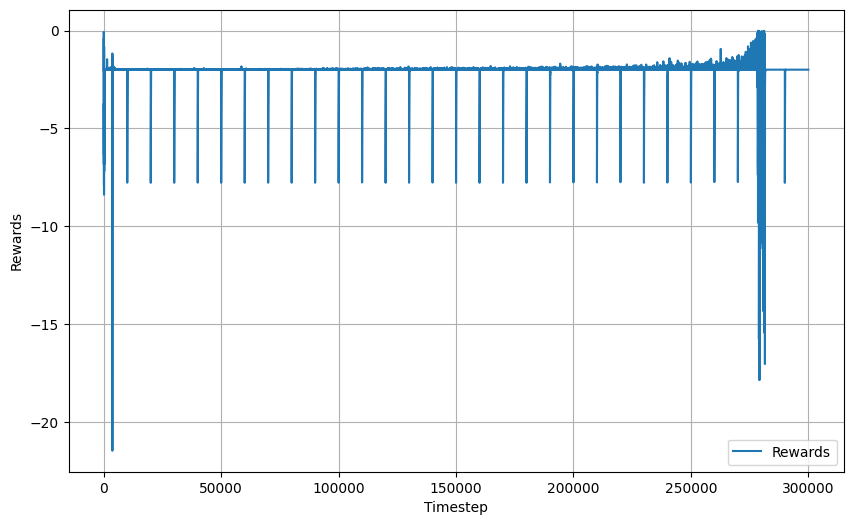

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(sac_callback.rewards, label="Rewards")
plt.xlabel("Timestep")
plt.ylabel("Rewards")
plt.legend()
plt.grid()
plt.savefig("rewards_plot.png")
plt.show()

In [ ]:
# 환경 초기화
env.reset()

# 모델 로드
model = SAC.load("results/sac_model_300000.zip", env=env)

sac_callback = CustomCallback(save_freq=10000, save_path="./results", verbose=1)
model.learn(total_timesteps=200000, reset_num_timesteps=False, callback=sac_callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model saved at timestep 310000
States, actions, rewards, and losses saved at timestep 310000
Model saved at timestep 320000
States, actions, rewards, and losses saved at timestep 320000
Model saved at timestep 330000
States, actions, rewards, and losses saved at timestep 330000
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+04     |
|    ep_rew_mean     | -2.06e+04 |
| time/              |           |
|    episodes        | 32        |
|    fps             | 57        |
|    time_elapsed    | 523       |
|    total_timesteps | 330000    |
| train/             |           |
|    actor_loss      | 46.7      |
|    critic_loss     | 0.176     |
|    ent_coef        | 0.005     |
|    learning_rate   | 0.002     |
|    n_updates       | 329898    |
----------------------------------
Model saved at timestep 340000
States, actions, rewards, and losses saved at timeste

ValueError: x and y must have same first dimension, but have shapes (80008,) and (79999,)

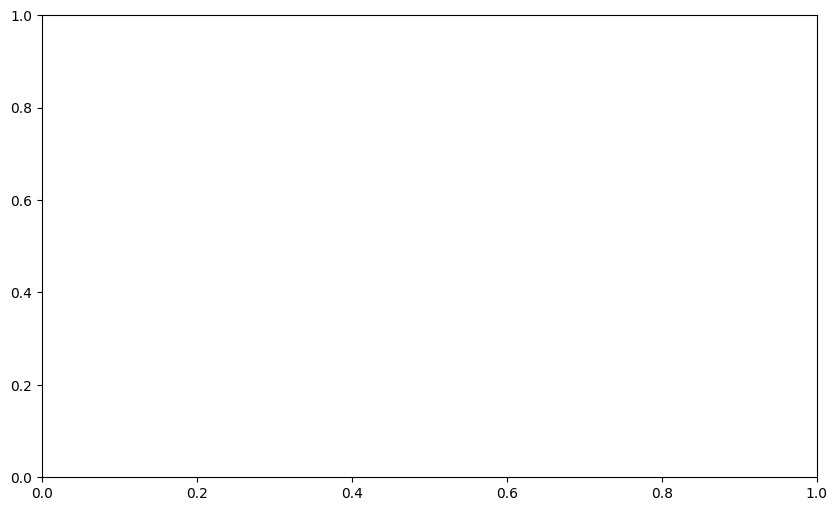

In [27]:
import matplotlib.pyplot as plt
float32 = np.float32
# 데이터 로드
with open("./results/actor_losses.txt", "r") as f:
    actor_losses = eval(f.read())  # 문자열 -> 리스트 변환
with open("./results/critic_losses.txt", "r") as f:
    critic_losses = eval(f.read())
# with open("./results/training_rewards.txt", "r") as f:
#     rewards = eval(f.read())
x_values = np.arange(300000, 390000 + len(actor_losses) * 10000, 10000)
# 그래프 생성
plt.figure(figsize=(10, 6))
plt.plot(x_values, actor_losses, label="Actor Loss", color="red")
plt.plot(x_values, critic_losses, label="Critic Loss", color="blue")
plt.xlabel("Step")
plt.ylabel("Loss")
# plt.title("Actor and Critic Loss over Timesteps")
plt.legend()
plt.grid()
plt.show()


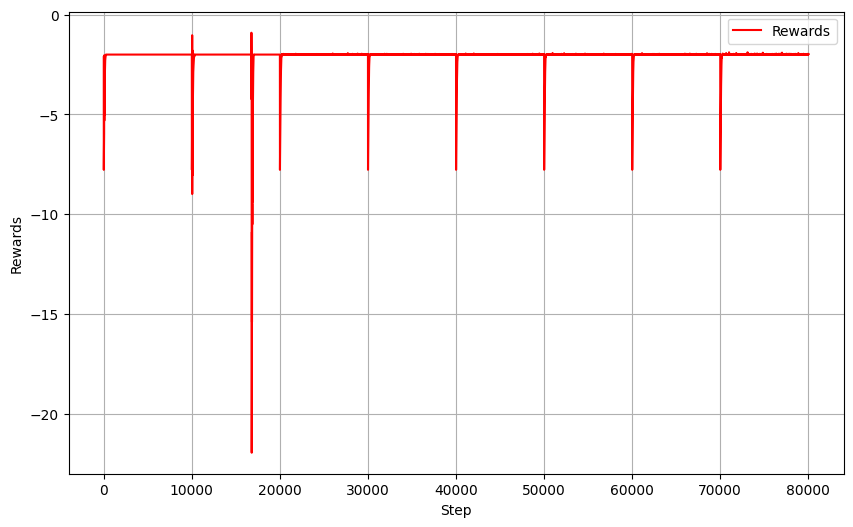

In [24]:
import matplotlib.pyplot as plt
float32 = np.float32
# 데이터 로드
with open("./results/training_rewards.txt", "r") as f:
    data = f.read()
array_list = eval(data.replace("array", "np.array"))
reshaped_arrays = [np.array([arr]) if arr.ndim == 0 else arr for arr in array_list]
combined_array = np.concatenate(reshaped_arrays, axis=0)
#     rewards = (np.concatenate(f.read().replace("array","np.array"), axis=0))
#     rewards = eval(np.concatenate(f.read().replace("array","np.array"), axis=0))
#     rewards = eval(np.vstack(f.read()))
# with open("./results/actor_losses.txt", "r") as f:
#     actor_losses = eval(f.read())  # 문자열 -> 리스트 변환
# with open("./results/critic_losses.txt", "r") as f:
#     critic_losses = eval(f.read())

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.plot(combined_array, label="Rewards", color="red")
# plt.plot(critic_losses, label="Critic Loss", color="blue")
plt.xlabel("Step")
plt.ylabel("Rewards")
# plt.title("Actor and Critic Loss over Timesteps")
plt.legend()
plt.grid()
plt.show()


In [32]:
print("Number of timesteps (states):", len(states))  # Should match actions
print("Number of actions:", len(combined_array))

Number of timesteps (states): 0
Number of actions: 80000


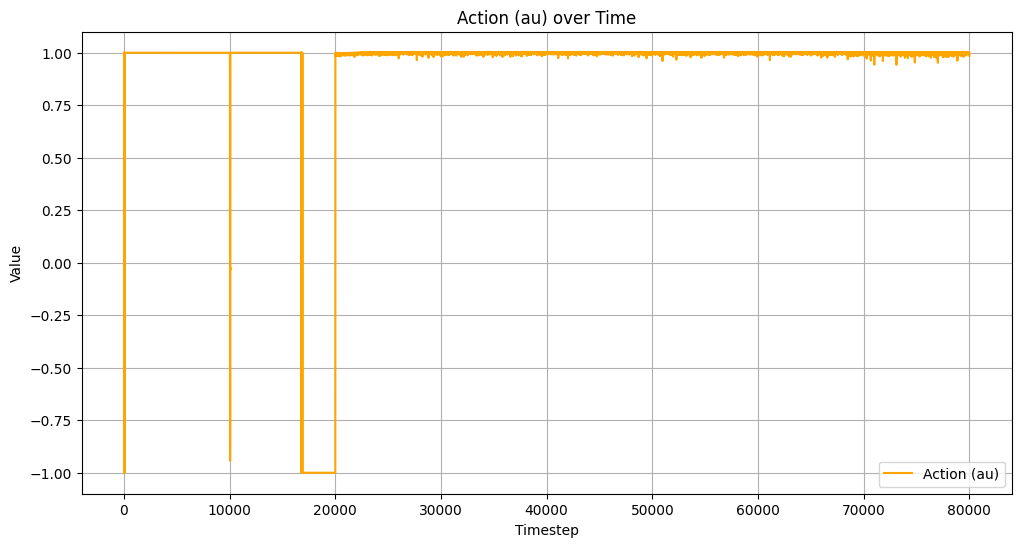

In [41]:
import matplotlib.pyplot as plt

# 데이터 로드
# with open("./results/states.txt", "r") as f:
#     states = eval(f.read())  # 문자열 -> 리스트 변환
with open("./results/actions.txt", "r") as f:
    data = f.read()
array_list = eval(data.replace("array", "np.array"))
reshaped_arrays = [np.array([arr]) if arr.ndim == 0 else arr for arr in array_list]
combined_array = np.concatenate(reshaped_arrays, axis=0)

# 시간축 생성
timesteps = range(len(combined_array))

# 그래프 생성
plt.figure(figsize=(12, 6))

# # x(t) 그래프
# plt.plot(timesteps, states, label="x(t)", color="black")

# action(au) 그래프
plt.plot(timesteps, combined_array, label="Action (au)", color="orange")
# plt.ylim(0.9, 1.1)
# 그래프 설정
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title("Action (au) over Time")
plt.legend()
plt.grid()
plt.show()